In [2]:
import torch
import matplotlib.pyplot as plt
import numbers

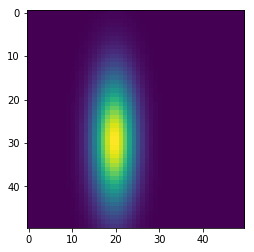

In [3]:
def gaussian_kernel_2d(mean, std_inv, size):

    if isinstance(size, numbers.Number):
        width = height = size
    else:
        width, height = size

    if isinstance(std_inv, numbers.Number):
        std_inv = torch.tensor([[std_inv, 0], [0, std_inv]])
    elif std_inv.dim() == 0:
        std_inv = torch.diag(std_inv.repeat(2))
    elif std_inv.dim() == 1:
        assert len(std_inv) == 2
        std_inv = torch.diag(std_inv)

    # squared 
    covariance_inv = std_inv.transpose(0, 1) @ std_inv
    covariance_inv = covariance_inv.float()

    # center the gaussian in (0, 0) and then shift to mean
    X = torch.cat([t.unsqueeze(-1) for t in reversed(torch.meshgrid([torch.arange(s) for s in [width, height]]))], dim=-1)
    X = X.float()
    X -= torch.tensor([(width - 1) / 2, (height - 1) / 2]).float()
    X -= mean.float()
    
    # does not use the normalize constant of gaussian distribution
    Y = torch.exp((-1 / 2) * torch.einsum('xyi,ij,xyj->xy', [X, covariance_inv, X]))

    # normalize
    Y /= Y.sum()
    return Y
    
kernel = gaussian_kernel_2d(torch.tensor([-5, 5]), 
#                             torch.tensor([[.3, .1],[.5, -.1]]),
                            torch.tensor([.3,.1]),
#                             torch.tensor([[.1,0], [0,.1]]), 
                            size=(50, 50))

plt.imshow(kernel)

In [6]:
X = torch.rand(10, 32, 100, 21)
num_heads = 7
attention_centers = torch.rand(num_heads, 2)
attention_alpha = torch.rand(num_heads)

In [7]:
import torch.nn.functional as F

In [8]:
batch, width, height, d_total = X.shape
d_head = d_total // num_heads
Y = X.permute(0, 3, 1, 2)

kernels = []
kernel_width = kernel_height = 11  # should be odd
for mean, std_inv in zip(attention_centers, attention_alpha):
    conv_weights = gaussian_kernel_2d(mean, std_inv, size=(kernel_width, kernel_height))
    conv_weights = conv_weights.unsqueeze(0).unsqueeze(0).repeat(d_head, 1, 1, 1)
    print(conv_weights.shape)
    kernels.append(conv_weights)

weights = torch.cat(kernels)
    
padding_width = (kernel_width - 1) // 2
padding_height = (kernel_height - 1) // 2
out = F.conv2d(Y, weights, groups=d_total, padding=(padding_width, padding_height))
out.shape

torch.Size([3, 1, 11, 11])
torch.Size([3, 1, 11, 11])
torch.Size([3, 1, 11, 11])
torch.Size([3, 1, 11, 11])
torch.Size([3, 1, 11, 11])
torch.Size([3, 1, 11, 11])
torch.Size([3, 1, 11, 11])


torch.Size([10, 21, 32, 100])

In [27]:
kernel

tensor([[2.3360e-12, 1.2916e-11, 6.5263e-11,  ..., 1.0476e-19, 8.4291e-21,
         6.1983e-22],
        [3.1219e-12, 1.7261e-11, 8.7220e-11,  ..., 1.4001e-19, 1.1265e-20,
         8.2836e-22],
        [4.1306e-12, 2.2838e-11, 1.1540e-10,  ..., 1.8525e-19, 1.4905e-20,
         1.0960e-21],
        ...,
        [3.9190e-11, 2.1668e-10, 1.0949e-09,  ..., 1.7576e-18, 1.4141e-19,
         1.0399e-20],
        [3.2734e-11, 1.8099e-10, 9.1455e-10,  ..., 1.4681e-18, 1.1812e-19,
         8.6858e-21],
        [2.7070e-11, 1.4967e-10, 7.5629e-10,  ..., 1.2140e-18, 9.7680e-20,
         7.1828e-21]])

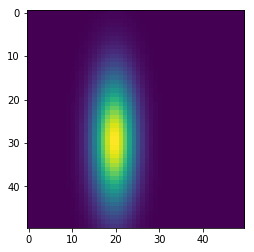

In [37]:
plt.imshow(kernel)

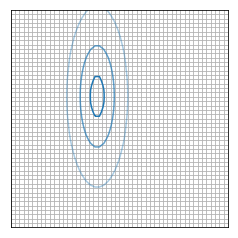

In [68]:
# from https://stackoverflow.com/questions/37890550/python-plotting-percentile-contour-lines-of-a-probability-distribution
import matplotlib
from matplotlib.mlab import bivariate_normal
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import matplotlib.colors as mcolors

# X, Y = np.mgrid[0:50:100j, -3:3:100j]
# z = 



def plot_contours_distribution(z, color='C0', contours=np.array([0.9, 0.5, 0.1]), ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    height, width = z.shape
        
    # compute integral for contours
    n = 1000
    t = np.linspace(0, z.max(), n)
    integral = ((z >= t[:, None, None]) * z).sum(axis=(1,2))
    
    # chose colors with level transparency
    min_contour = contours.min()
    max_contour = contours.max()
    min_alpha = 0.3
    alphas = min_alpha + (1 - min_alpha) * (1 - (contours - min_contour) / max_contour)
    colors = [mcolors.to_rgba(color, alpha) for alpha in alphas]

    f = interpolate.interp1d(integral, t)
    t_contours = f(np.array(contours))
    ax.contour(z, t_contours, extent=[0, width, 0, height], colors=colors)
    

    # draw the grid
    ax.set_xticks(np.arange(width))#, minor=True)
    ax.set_aspect(1)
    ax.set_yticks(np.arange(height))#, minor=True)
    plt.tick_params(
        axis='both',         
        which='both',      
        bottom=False,     
        top=False,
        left=False,
        labelbottom=False,
        labelleft=False)
    plt.grid(True)
    
    return ax

plot_contours_distribution(kernel.numpy())

In [34]:
kernel.numpy()


array([[2.33597191e-12, 1.29155115e-11, 6.52633017e-11, ...,
        1.04762089e-19, 8.42914412e-21, 6.19830505e-22],
       [3.12185412e-12, 1.72606287e-11, 8.72195927e-11, ...,
        1.40007065e-19, 1.12649503e-20, 8.28359335e-22],
       [4.13062119e-12, 2.28380682e-11, 1.15402916e-10, ...,
        1.85247292e-19, 1.49049739e-20, 1.09602562e-21],
       ...,
       [3.91902413e-11, 2.16681534e-10, 1.09491238e-09, ...,
        1.75757724e-18, 1.41414449e-19, 1.03988017e-20],
       [3.27344298e-11, 1.80987572e-10, 9.14547382e-10, ...,
        1.46805161e-18, 1.18119246e-19, 8.68580679e-21],
       [2.70700233e-11, 1.49669263e-10, 7.56293639e-10, ...,
        1.21402031e-18, 9.76799232e-20, 7.18281719e-21]], dtype=float32)

In [65]:
mcolors.to_rgb('red')

(1.0, 0.0, 0.0)